In [1]:
### TODO import libraries and apply overlay

### Lib for downloading images
from simple_image_download import simple_image_download as simp
from IPython.display import Image

### Lib for os-path interaction
import os
from pathlib import Path

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pynq import Xlnk, Overlay

In [22]:
### TODO download cat images into the folder `simple_images/cat/`
response = simp.simple_image_download
searchterm = 'cat'

response().download(searchterm, 15)

In [23]:
Thumbail_Width = 64

In [22]:
### CPU Resizer Function
def cpu_resize_images(image_path, img_num):
    
    ### Create an Image object
    original_image = Image.open(image_path)
    
    ### Resizing
    old_width, old_height = original_image.size
    print("old image size: {}x{} pixels.".format(old_width, old_height))
    
    new_width = Thumbail_Width
    resize_factor = int(old_width/new_width + 0.5)
    new_height = int(old_height/resize_factor + 0.5)
    
    # new_width = int(old_width/resize_factor + 0.5)
    # new_height = int(old_height/resize_factor + 0.5)
    
    resized_image = original_image.resize((new_width, new_height), Image.BILINEAR)
    
    res_width, res_height = resized_image.size
    print("new image size: {}x{} pixels.".format(res_width, res_height))
    
    ### Save Image
    resized_image.save(r"result_images/Software/resized_cat_"+str(img_num)+".jpg")

    return resized_image

In [25]:
### Hardware Resizer Function
def fpga_resize_images(image_path, img_num):
    
    ## Save result image to the following directory!
    res_directory = 'result_images'
    
    resize_design = Overlay("resizer.bit")
    dma = resize_design.axi_dma_0
    resizer = resize_design.resize_accel_0
    
    ### Create an Image object
    original_image = Image.open(image_path)
    
    ### Resizing
    old_width, old_height = original_image.size
    print("Image size: {}x{} pixels.".format(old_width, old_height))
    
    if(old_width > 4000 or old_height > 4000):
        print("Picture to large for the image resizer,... yes, really")
        return()
    
    new_width = Thumbail_Width
    resize_factor = int(old_width/new_width + 0.5)
    new_height = int(old_height/resize_factor + 0.5)
    
    # new_width = int(old_width/resize_factor + 0.5)
    # new_height = int(old_height/resize_factor + 0.5)
    
    ###Create Hardware Buffer
    xlnk = Xlnk()
    in_buffer = xlnk.cma_array(shape=(old_height, old_width, 3), dtype=np.uint8, cacheable=1)
    out_buffer = xlnk.cma_array(shape=(new_height, new_width, 3), dtype=np.uint8, cacheable=1)
    
    in_buffer[:] = np.array(original_image)
        
    ### Write dimension data to MMIO register
    resizer.write(0x10, old_height)
    resizer.write(0x18, old_width)
    resizer.write(0x20, new_height)
    resizer.write(0x28, new_width)
    
    ### Run Kernel
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    resizer.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
    ### Readout resized image
    resized_image = Image.fromarray(out_buffer)
    
    res_width, res_height = resized_image.size
    print("Image size: {}x{} pixels.".format(res_width, res_height))
    
    ### Save Image
    resized_image.save(r"result_images/Hardware/resized_cat_"+str(img_num)+".jpg")
    
    # Reset Memory buffer
    xlnk.xlnk_reset()
    
    return resized_image

In [5]:
## Call CPU resizer in for loop for every picture!
def software():
    directory = 'simple_images/cat'
    img_num = 1

    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            try:
                original_image = Image.open(os.path.join(directory, filename))
            except OSError:
                print("ERROR: Picture " + filename + " could not be opened!")
            else:
                print("Resize picture " + filename)
                cpu_resize_images(os.path.join(directory, filename), img_num)
                img_num += 1;
        else:
            continue


In [6]:
## Call Hardware resizer in for loop for every picture!
def hardware():
    directory = 'simple_images/cat'
    img_num = 1

    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            try:
                original_image = Image.open(os.path.join(directory, filename))
            except OSError:
                print("ERROR: Picture " + filename + " could not be opened!")
            else:
                print("Resize picture " + filename)
                fpga_resize_images(os.path.join(directory, filename), img_num)
                img_num += 1;
        else:
            continue


In [5]:
# TODO runtime comparison

In [40]:
# TODO timeit fpga_resize_images(image_paths)
hard_time = []

for x in [64, 256, 512]:
    Thumbail_Width = x

    a = %timeit -n 1 -r 1 -o hardware()
    hard_time.append(a.best)

Resize picture cat_7.jpg
Image size: 2800x1575 pixels.


/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: pynq.Xlnk is deprecated and will be removed in 2.7 - use pynq.allocate instead


Image size: 64x37 pixels.
Resize picture cat_1.jpg
Image size: 1200x600 pixels.
Image size: 64x33 pixels.
Resize picture cat_10.jpg
Image size: 1200x1200 pixels.
Image size: 64x67 pixels.
Resize picture cat_11.jpg


/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Image size: 5000x3333 pixels.
Picture to large for the image resizer,... yes, really
Resize picture cat_12.jpg
Image size: 1200x1199 pixels.
Image size: 64x67 pixels.
ERROR: Picture cat_9.jpg could not be opened!
Resize picture cat_13.jpg
Image size: 976x549 pixels.
Image size: 64x37 pixels.
Resize picture cat_15.jpg
Image size: 1240x698 pixels.
Image size: 64x37 pixels.
Resize picture cat_4.jpg
Image size: 1800x1200 pixels.
Image size: 64x43 pixels.
Resize picture cat_8.jpg
Image size: 1240x698 pixels.
Image size: 64x37 pixels.
Resize picture cat_6.jpg
Image size: 976x549 pixels.
Image size: 64x37 pixels.
Resize picture cat_14.jpg
Image size: 2120x1415 pixels.
Image size: 64x43 pixels.
ERROR: Picture cat_3.jpg could not be opened!
Resize picture cat_2.jpg
Image size: 2187x2187 pixels.
Image size: 64x64 pixels.
Resize picture cat_5.jpg
Image size: 955x770 pixels.
Image size: 64x55 pixels.
1 loop, best of 1: 15.5 s per loop
Resize picture cat_7.jpg
Image size: 2800x1575 pixels.


/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: pynq.Xlnk is deprecated and will be removed in 2.7 - use pynq.allocate instead


Image size: 256x158 pixels.
Resize picture cat_1.jpg
Image size: 1200x600 pixels.
Image size: 256x150 pixels.
Resize picture cat_10.jpg
Image size: 1200x1200 pixels.
Image size: 256x300 pixels.
Resize picture cat_11.jpg


/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Image size: 5000x3333 pixels.
Picture to large for the image resizer,... yes, really
Resize picture cat_12.jpg
Image size: 1200x1199 pixels.
Image size: 256x300 pixels.
ERROR: Picture cat_9.jpg could not be opened!
Resize picture cat_13.jpg
Image size: 976x549 pixels.
Image size: 256x183 pixels.
Resize picture cat_15.jpg
Image size: 1240x698 pixels.
Image size: 256x175 pixels.
Resize picture cat_4.jpg
Image size: 1800x1200 pixels.
Image size: 256x171 pixels.
Resize picture cat_8.jpg
Image size: 1240x698 pixels.
Image size: 256x175 pixels.
Resize picture cat_6.jpg
Image size: 976x549 pixels.
Image size: 256x183 pixels.
Resize picture cat_14.jpg
Image size: 2120x1415 pixels.
Image size: 256x177 pixels.
ERROR: Picture cat_3.jpg could not be opened!
Resize picture cat_2.jpg
Image size: 2187x2187 pixels.
Image size: 256x273 pixels.
Resize picture cat_5.jpg
Image size: 955x770 pixels.
Image size: 256x257 pixels.
1 loop, best of 1: 15.5 s per loop
Resize picture cat_7.jpg
Image size: 2800x157

/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: pynq.Xlnk is deprecated and will be removed in 2.7 - use pynq.allocate instead


Image size: 512x315 pixels.
Resize picture cat_1.jpg
Image size: 1200x600 pixels.
Image size: 512x300 pixels.
Resize picture cat_10.jpg
Image size: 1200x1200 pixels.
Image size: 512x600 pixels.
Resize picture cat_11.jpg


/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Image size: 5000x3333 pixels.
Picture to large for the image resizer,... yes, really
Resize picture cat_12.jpg
Image size: 1200x1199 pixels.
Image size: 512x600 pixels.
ERROR: Picture cat_9.jpg could not be opened!
Resize picture cat_13.jpg
Image size: 976x549 pixels.
Image size: 512x549 pixels.
Resize picture cat_15.jpg
Image size: 1240x698 pixels.
Image size: 512x349 pixels.
Resize picture cat_4.jpg
Image size: 1800x1200 pixels.
Image size: 512x400 pixels.
Resize picture cat_8.jpg
Image size: 1240x698 pixels.
Image size: 512x349 pixels.
Resize picture cat_6.jpg
Image size: 976x549 pixels.
Image size: 512x549 pixels.
Resize picture cat_14.jpg
Image size: 2120x1415 pixels.
Image size: 512x354 pixels.
ERROR: Picture cat_3.jpg could not be opened!
Resize picture cat_2.jpg
Image size: 2187x2187 pixels.
Image size: 512x547 pixels.
Resize picture cat_5.jpg
Image size: 955x770 pixels.
Image size: 512x770 pixels.
1 loop, best of 1: 15 s per loop


In [42]:
# TODO timeit cpu_resize_images(image_paths)
soft_time = []

for x in [64, 256, 512]:
    Thumbail_Width = x

    a = %timeit -n 1 -r 1 -o software()
    soft_time.append(a.best)

Resize picture cat_7.jpg
old image size: 2800x1575 pixels.
new image size: 64x37 pixels.
Resize picture cat_1.jpg
old image size: 1200x600 pixels.
new image size: 64x33 pixels.
Resize picture cat_10.jpg
old image size: 1200x1200 pixels.
new image size: 64x67 pixels.
Resize picture cat_11.jpg
old image size: 5000x3333 pixels.


/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


new image size: 64x43 pixels.
Resize picture cat_12.jpg
old image size: 1200x1199 pixels.
new image size: 64x67 pixels.
ERROR: Picture cat_9.jpg could not be opened!
Resize picture cat_13.jpg
old image size: 976x549 pixels.
new image size: 64x37 pixels.
Resize picture cat_15.jpg
old image size: 1240x698 pixels.
new image size: 64x37 pixels.
Resize picture cat_4.jpg
old image size: 1800x1200 pixels.
new image size: 64x43 pixels.
Resize picture cat_8.jpg
old image size: 1240x698 pixels.
new image size: 64x37 pixels.
Resize picture cat_6.jpg
old image size: 976x549 pixels.
new image size: 64x37 pixels.
Resize picture cat_14.jpg
old image size: 2120x1415 pixels.
new image size: 64x43 pixels.
ERROR: Picture cat_3.jpg could not be opened!
Resize picture cat_2.jpg
old image size: 2187x2187 pixels.
new image size: 64x64 pixels.
Resize picture cat_5.jpg
old image size: 955x770 pixels.
new image size: 64x55 pixels.
1 loop, best of 1: 7.05 s per loop
Resize picture cat_7.jpg
old image size: 2800x

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


new image size: 256x175 pixels.
Resize picture cat_12.jpg
old image size: 1200x1199 pixels.
new image size: 256x300 pixels.
ERROR: Picture cat_9.jpg could not be opened!
Resize picture cat_13.jpg
old image size: 976x549 pixels.
new image size: 256x183 pixels.
Resize picture cat_15.jpg
old image size: 1240x698 pixels.
new image size: 256x175 pixels.
Resize picture cat_4.jpg
old image size: 1800x1200 pixels.
new image size: 256x171 pixels.
Resize picture cat_8.jpg
old image size: 1240x698 pixels.
new image size: 256x175 pixels.
Resize picture cat_6.jpg
old image size: 976x549 pixels.
new image size: 256x183 pixels.
Resize picture cat_14.jpg
old image size: 2120x1415 pixels.
new image size: 256x177 pixels.
ERROR: Picture cat_3.jpg could not be opened!
Resize picture cat_2.jpg
old image size: 2187x2187 pixels.
new image size: 256x273 pixels.
Resize picture cat_5.jpg
old image size: 955x770 pixels.
new image size: 256x257 pixels.
1 loop, best of 1: 7.6 s per loop
Resize picture cat_7.jpg
ol

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


new image size: 512x370 pixels.
Resize picture cat_12.jpg
old image size: 1200x1199 pixels.
new image size: 512x600 pixels.
ERROR: Picture cat_9.jpg could not be opened!
Resize picture cat_13.jpg
old image size: 976x549 pixels.
new image size: 512x549 pixels.
Resize picture cat_15.jpg
old image size: 1240x698 pixels.
new image size: 512x349 pixels.
Resize picture cat_4.jpg
old image size: 1800x1200 pixels.
new image size: 512x400 pixels.
Resize picture cat_8.jpg
old image size: 1240x698 pixels.
new image size: 512x349 pixels.
Resize picture cat_6.jpg
old image size: 976x549 pixels.
new image size: 512x549 pixels.
Resize picture cat_14.jpg
old image size: 2120x1415 pixels.
new image size: 512x354 pixels.
ERROR: Picture cat_3.jpg could not be opened!
Resize picture cat_2.jpg
old image size: 2187x2187 pixels.
new image size: 512x547 pixels.
Resize picture cat_5.jpg
old image size: 955x770 pixels.
new image size: 512x770 pixels.
1 loop, best of 1: 8.3 s per loop


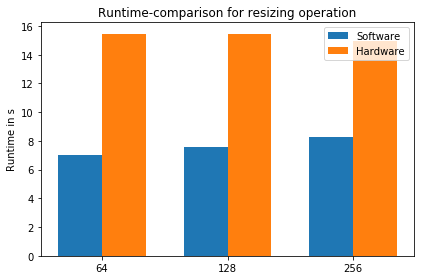

In [43]:
labels = ['64', '128', '256']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, soft_time, width, label='Software')
rects2 = ax.bar(x + width/2, hard_time, width, label='Hardware')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()